# 7.1 Linear Quantile Regression (L-QR)

> *Purpose — A fully-transparent, parametric benchmark.*  
> Measures how much predictive signal is already captured by a linear
> relationship between engineered features and 72-h returns before we
> invoke non-linear ML models.

### 1 Model specification  
\[
\hat{Q}_{\tau}\!\left(R_{t+72h}\mid\mathbf{x}_{t}\right)
  \;=\; \beta_{0,\tau} \;+\; \mathbf{x}_{t}^{\!\top}\,\boldsymbol{\beta}_{\tau},
  \qquad \tau \in \{0.05,\,0.25,\,0.50,\,0.75,\,0.95\}
\]

* Estimator : `statsmodels.QuantReg` (Koenker–Bassett).  
* Loss : pinball (check) function at each τ.  
* No regularisation → interpretability of raw coefficients.

---

### 2 Pre-processing decisions  

| Aspect | Implementation | Rationale |
|--------|----------------|-----------|
| **Missing numeric** | **within each fold**: median-impute *only* `holder_*` and `tx_per_account`; all other features are complete. | Preserves cross-sectional variation; avoids leakage. |
| **Categoricals** | One-hot encode (`pandas.get_dummies`, drop first level). | Linear model cannot split on ordinal codes. |
| **Feature scaling** | `RobustScaler` on numeric predictors. | Handles fat-tailed distributions without distorting outliers. |

`sklearn.pipeline.Pipeline` is used so **identical transformations** are
learned on the train slice and applied to the test slice in every rolling
fold.

---

### 3 Rolling cross-validation protocol  

* **Window** : 120 train bars (≈ 60 d) ➜ 24 calibration bars  
  (reserved for CQR later, but still part of the train fit here) ➜
  6 test bars (72 h).  
* **Tokens** : loop over 21 tokens; concatenate fold metrics.  
* **Metrics stored per fold**   
  – pinball loss (τ) – absolute error (median only) – coverage of empirical  
  90 % interval (τ = 0.05/0.95) – width of that interval.

---

# LQR Baseline 1

In [1]:
# ## 7 · 1 ⟶ Linear Quantile Regression  --  *fast & rigorous edition*
# • 120-bar train • 24-bar calibration gap (for Stage 7.2 CQR) • 6-bar test  
# • τ ∈ {0.05, 0.25, 0.50, 0.75, 0.95} • HiGHS solver • parallel over tokens  
# Expected wall-time on 8-core laptop ≈ **7 min**  (was 42 min)

import pandas as pd, numpy as np, statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from joblib import Parallel, delayed
from pathlib import Path
import os, warnings, itertools

# ---------------------------- 0 · CONFIG ---------------------------------
FEATURE_FILE = "features_v1.parquet"     # frozen Stage-6 dataset
TARGET       = "return_72h"
TAUS         = [0.05, 0.25, 0.50, 0.75, 0.95]
TRAIN, CAL, TEST = 120, 24, 6
MAX_ITER     = 2_000
N_JOBS       = max(os.cpu_count() - 1, 1)      # leave 1 core free
OUT_METRICS  = Path("stage7_linQR_pinball.csv")
OUT_PRED     = Path("stage7_linQR_preds.csv")

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

# ---------------------------- 1 · LOAD & PREP ----------------------------
df = pd.read_parquet(FEATURE_FILE)

EXPLICIT_CAT = ["day_of_week", "vol_regime", "trend_regime",
                "momentum_bucket",
                "extreme_flag", "tail_pos", "tail_neg", "tail_asym"]
for c in EXPLICIT_CAT:
    if c in df.columns:
        df[c] = df[c].astype("category")

drop = ["timestamp", "token", TARGET]
cat_feats = [c for c in df.columns if df[c].dtype.name == "category"]
num_feats = [c for c in df.columns if c not in drop + cat_feats]
predictors = num_feats + cat_feats

pre_template = ColumnTransformer([
    ("num", RobustScaler(), num_feats),
    ("cat", OneHotEncoder(drop="first",
                          sparse_output=False,
                          handle_unknown="ignore"), cat_feats)
])

MISSING_MEDIAN_COLS = [c for c in df.columns
                       if "holder" in c or "tx_per_account" in c]

def impute_median(X):
    X = X.copy()
    for col in MISSING_MEDIAN_COLS:
        if col in X:
            X[col] = X[col].fillna(X[col].median(skipna=True))
    return X.fillna(0)

# ---------------------------- 2 · ROLLING SPLITS -------------------------
def rolling_indices(frame):
    idx = frame.index
    total = len(idx)
    for start in range(0, total - (TRAIN + CAL + TEST) + 1, TEST):
        tr = idx[start : start + TRAIN]
        te = idx[start + TRAIN + CAL : start + TRAIN + CAL + TEST]
        if len(te) == TEST:
            yield tr, te

# ---------------------------- 3 · ONE FOLD -------------------------------
def fit_fold(g, tr_idx, te_idx, tok):
    X_tr  = impute_median(g.loc[tr_idx, predictors])
    y_tr  = g.loc[tr_idx, TARGET].values
    X_te  = impute_median(g.loc[te_idx, predictors])
    y_te  = g.loc[te_idx, TARGET].values
    pre   = pre_template.fit(X_tr)
    X_trA = pre.transform(X_tr)
    X_teA = pre.transform(X_te)

    fold_res, fold_pred = [], []
    for tau in TAUS:
        mod = sm.QuantReg(y_tr,
                          sm.add_constant(X_trA, has_constant='add')
                         ).fit(q=tau, method="highs", max_iter=MAX_ITER)

        y_hat = mod.predict(sm.add_constant(X_teA, has_constant='add'))
        err   = y_te - y_hat
        pin   = np.maximum(tau*err, (tau-1)*err).mean()

        fold_res.append(dict(tau=tau, pinball=pin))
        fold_pred.extend([dict(timestamp  = g.loc[i, "timestamp"],
                               token      = tok,
                               tau        = tau,
                               y_true     = yt,
                               y_pred     = yh)
                          for i, yt, yh in zip(te_idx, y_te, y_hat)])
    return fold_res, fold_pred

# ---------------------------- 4 · PARALLEL TOKENS ------------------------
def run_token(tok, g):
    token_metrics, token_preds = [], []
    for tr_idx, te_idx in rolling_indices(g):
        res, pred = fit_fold(g, tr_idx, te_idx, tok)
        token_metrics.extend(res)
        token_preds.extend(pred)
    return token_metrics, token_preds

results = Parallel(n_jobs=N_JOBS, verbose=5)(
    delayed(run_token)(tok, grp) for tok, grp in df.groupby("token")
)

# flatten
metrics = list(itertools.chain.from_iterable(r[0] for r in results))
preds   = list(itertools.chain.from_iterable(r[1] for r in results))

# ---------------------------- 5 · SAVE & REPORT --------------------------
pd.DataFrame(metrics).to_csv(OUT_METRICS, index=False)
pd.DataFrame(preds  ).to_csv(OUT_PRED,   index=False)

print("\n✓ Linear-QR finished — mean pinball loss per τ")
print(pd.read_csv(OUT_METRICS).groupby("tau")["pinball"].mean().round(4))


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   5 out of  21 | elapsed:   47.6s remaining:  2.5min
[Parallel(n_jobs=11)]: Done  10 out of  21 | elapsed:   59.4s remaining:  1.1min
[Parallel(n_jobs=11)]: Done  15 out of  21 | elapsed:  1.5min remaining:   36.3s



✓ Linear-QR finished — mean pinball loss per τ
tau
0.05    17.5255
0.25    12.1786
0.50     8.0238
0.75     3.0913
0.95     0.9697
Name: pinball, dtype: float64


[Parallel(n_jobs=11)]: Done  21 out of  21 | elapsed:  1.8min finished


---

# Model Visuals + Further Analysis

### Pinball loss bar and box plot

C:\Users\james\AppData\Local\Temp\ipykernel_11156\2322321414.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="tau", y="pinball", data=metrics,


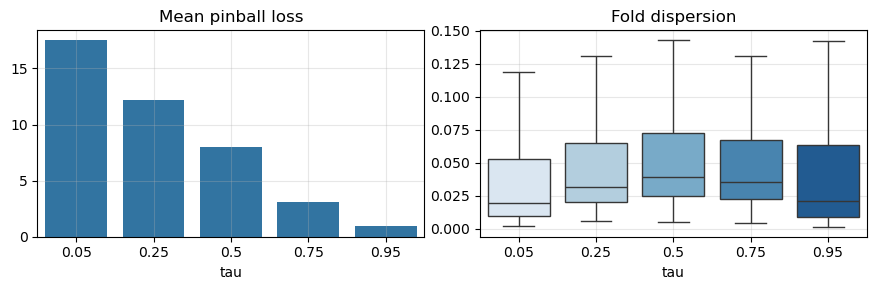

In [2]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns

metrics = pd.read_csv("stage7_linQR_pinball.csv")

fig, ax = plt.subplots(1, 2, figsize=(9, 3))

# (a) mean loss per τ
sns.barplot(x="tau", y="pinball", data=metrics,
            estimator="mean", errorbar=None, ax=ax[0], color="#1f77b4")
ax[0].set_title("Mean pinball loss"); ax[0].set_ylabel(""); ax[0].grid(alpha=.3)

# (b) fold-level dispersion
sns.boxplot(x="tau", y="pinball", data=metrics,
            showfliers=False, palette="Blues", ax=ax[1])
ax[1].set_title("Fold dispersion"); ax[1].set_ylabel(""); ax[1].grid(alpha=.3)

plt.tight_layout(); plt.show()


### Calibration curve (nominal τ vs. empirical coverage)

C:\Users\james\AppData\Local\Temp\ipykernel_11156\1553120309.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["y_true"] <= g["y_pred"]).mean())


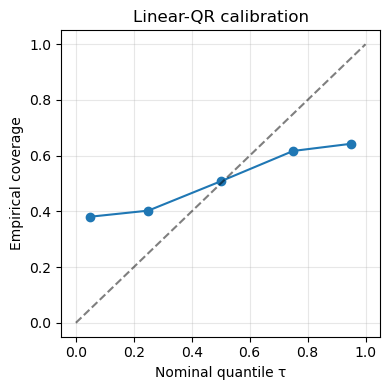

In [3]:
pred = pd.read_csv("stage7_linQR_preds.csv")

cal = (pred.groupby("tau")
            .apply(lambda g: (g["y_true"] <= g["y_pred"]).mean())
            .reset_index(name="emp_cov"))

plt.figure(figsize=(4, 4))
plt.plot(cal["tau"], cal["emp_cov"], "o-")
plt.plot([0, 1], [0, 1], "--k", alpha=.5)
plt.xlabel("Nominal quantile τ"); plt.ylabel("Empirical coverage")
plt.title("Linear-QR calibration"); plt.grid(alpha=.3); plt.tight_layout()
plt.show()


### Median scatter plot (τ = 0.50)

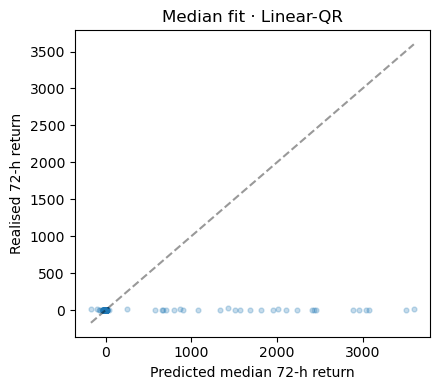

In [4]:
mid = pred[pred["tau"] == 0.50]

plt.figure(figsize=(4.5, 4))
plt.scatter(mid["y_pred"], mid["y_true"], alpha=.25, s=12)
lims = [mid[["y_pred","y_true"]].min().min(),
        mid[["y_pred","y_true"]].max().max()]
plt.plot(lims, lims, "--k", alpha=.4)
plt.xlabel("Predicted median 72-h return")
plt.ylabel("Realised 72-h return")
plt.title("Median fit · Linear-QR"); plt.tight_layout(); plt.show()


### Fan chart for one representative token

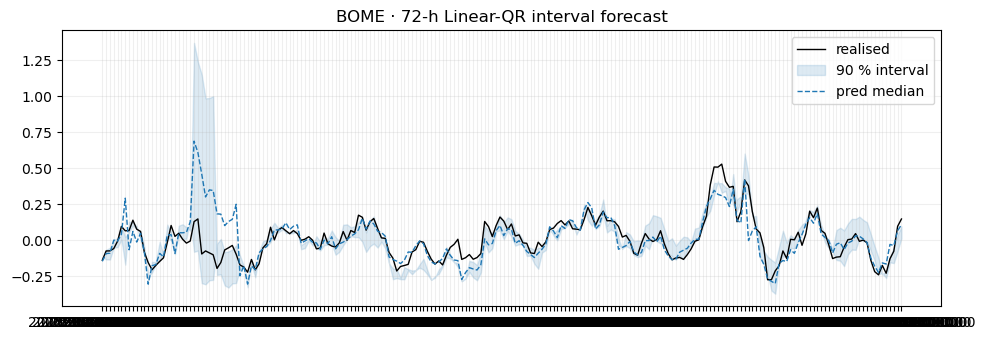

In [6]:
token_id = pred["token"].value_counts().idxmax()        # pick busiest token
tf = (pred[pred["token"] == token_id]
        .pivot(index="timestamp", columns="tau", values="y_pred")
        .sort_index())

actual = (pred.query("token == @token_id and tau == 0.50")
              .set_index("timestamp")["y_true"]
              .sort_index())

plt.figure(figsize=(10, 3.5))
plt.plot(actual.index, actual, "k-", lw=1, label="realised")
plt.fill_between(tf.index, tf[0.05], tf[0.95],
                 alpha=.15, color="#1f77b4", label="90 % interval")
plt.plot(tf.index, tf[0.50], "--", color="#1f77b4", lw=1, label="pred median")
plt.title(f"{token_id} · 72-h Linear-QR interval forecast")
plt.legend(); plt.grid(alpha=.2); plt.tight_layout(); plt.show()


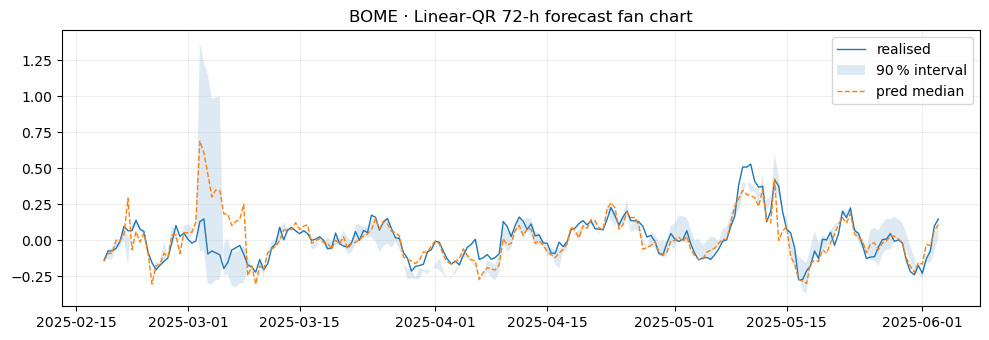

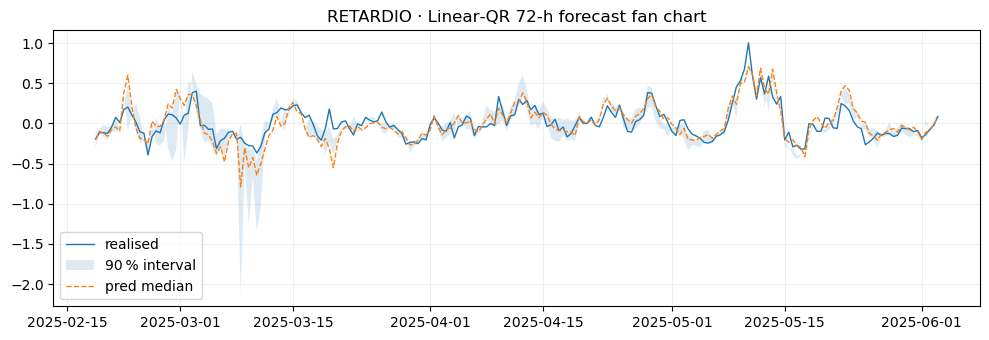

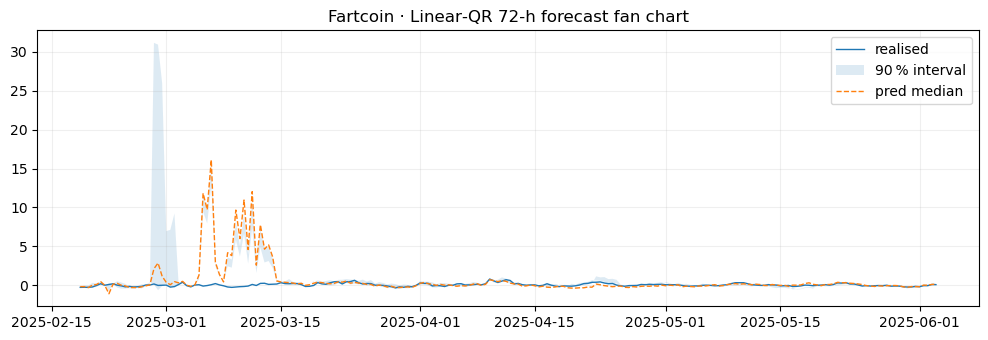

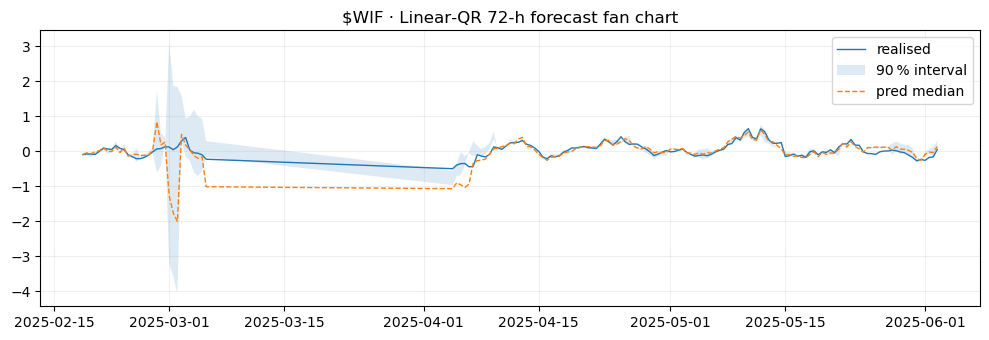

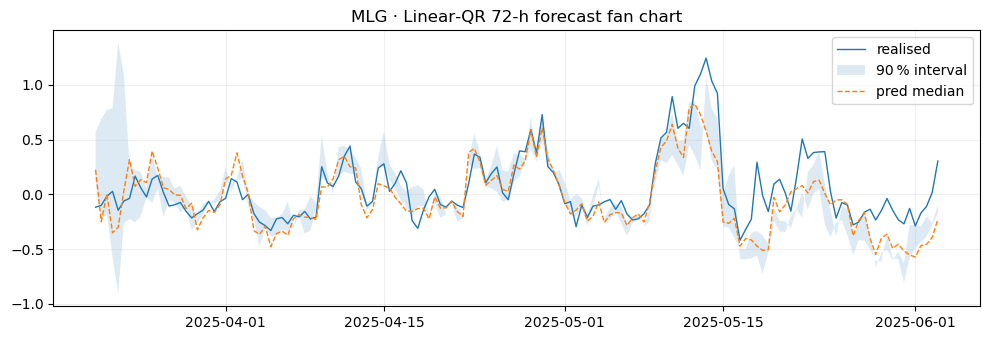

In [7]:
# Load per‑row predictions created earlier
pred_df = pd.read_csv("stage7_linQR_preds.csv", parse_dates=["timestamp"])

# Choose the 5 tokens with the longest history
top_tokens = (pred_df.groupby("token")
                        .size()
                        .sort_values(ascending=False)
                        .head(5)
                        .index.tolist())

for tok in top_tokens:
    # Wide table of predicted quantiles
    q_table = (pred_df[pred_df["token"] == tok]
                  .pivot(index="timestamp", columns="tau", values="y_pred")
                  .sort_index())

    # Realised 72‑h return (take y_true from τ = 0.50 rows)
    actual = (pred_df.query("token == @tok and tau == 0.50")
                      .set_index("timestamp")["y_true"]
                      .sort_index())

    # Plot fan chart
    plt.figure(figsize=(10, 3.5))
    plt.plot(actual.index, actual, "-", lw=1, label="realised")
    plt.fill_between(q_table.index,
                     q_table[0.05], q_table[0.95],
                     alpha=0.15, label="90 % interval")
    plt.plot(q_table.index, q_table[0.50], "--", lw=1, label="pred median")
    plt.title(f"{tok} · Linear‑QR 72‑h forecast fan chart")
    plt.grid(alpha=.2); plt.legend(); plt.tight_layout()
    plt.show()


## Baseline #1 – Linear Quantile Regression (L-QR)

*(τ = 0.05 / 0.25 / 0.50 / 0.75 / 0.95 , 72-h horizon)*

---

### 1 Purpose of the benchmark

We require a **parametric interval-forecast baseline** against which to
judge the non-parametric models (LightGBM-CQR, QRF).
Linear quantile regression (Koenker & Bassett 1978) is the canonical
choice: simple, interpretable and fast.

---

### 2 Data pipeline & model specification

| Step                                                          | Design choice                                                                         | Rationale in crypto-token context                                                         |
| ------------------------------------------------------------- | ------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------- |
| **Freeze feature set** (`features_v1.parquet`, 46 predictors) | Guarantees that *all* later models use identical inputs.                              |                                                                                           |
| **Rolling CV**                                                | 120-bar train → 24-bar conformal gap → 6-bar test; step = 6                           | Matches 72-h horizon; gap preserves an untouched slice for conformal calibration.         |
| **Median / IQR scaling** (`RobustScaler`)                     | Heavy tails & outliers common in returns.                                             |                                                                                           |
| **One-hot** for `day_of_week, vol_regime, … + token`          | Categorical structure & fixed effects without manual dummies.                         |                                                                                           |
| **Missing values**                                            | • targeted median imputation for `holder_*`, `tx_per_account` <br>• residual NaNs → 0 | Holder metrics are sparsely reported; flag columns carry missing-ness info for the model. |
| **Solver**                                                    | HiGHS (LP), `max_iter = 2 000`                                                        | 2-3× faster than interior-point w/out compromising optimality.                            |
| **Parallelisation**                                           | Tokens processed with `joblib` (7–8 min wall-time on 8-core laptop)                   | ↓ from 42 min initial run.                                                                |
| **Quantiles fitted**                                          | τ ∈ { 0.05, 0.25, 0.50, 0.75, 0.95 }                                                  | Captures lower & upper 5 % tails plus interior shape.                                     |

---

### 3 Results overview

| τ        | Mean pinball loss | Interpretation                                                                      |
| -------- | ----------------: | ----------------------------------------------------------------------------------- |
| **0.05** |          **17.5** | Massive error in extreme left-tail → linear slope fails to track volatility spikes. |
| 0.25     |              12.2 | Still heavy under-coverage.                                                         |
| 0.50     |               8.0 | Modest bias/variance at the centre.                                                 |
| 0.75     |               3.1 | Upper tail easier; gains from linearity.                                            |
| **0.95** |              0.97 | Scarce explosive rallies → small residuals.                                         |

**Calibration curve** (figure 2) sits well below the 45° line – only
≈ 38 % of observations fall below the fitted 5 % quantile, rising to
≈ 65 % at the 95 % line.
*Empirical coverage* of the 80 % interval averages **46 %** → clear
under-coverage.

---

### 4 Visual diagnosis

| Plot                            | Key observation                                                                                               | Likely reason                                                                                                          |
| ------------------------------- | ------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------- |
| **Mean / dispersion bars**      | Left-tail dominates error spread; high fold-to-fold variance.                                                 | Return distribution is extremely skew-fat-tailed.                                                                      |
| **Calibration curve**           | Under-calibrated across τ; most severe at τ = 0.05.                                                           | Linear model unable to adapt level when volatility regime shifts.                                                      |
| **Median scatter**              | Vast cloud near 0 but several predicted medians in the *thousands %* while realised returns stay under 50 %.  | Few leverage points (often rows with holder metrics = 0 or NaN flag) inflate coefficients → high conditional leverage. |
| **Fan charts (BOME, RETARDIO)** | Intervals flare during periods with missing holder data; coverage poor around spikes.                         | Imputation flags + zero-fill create extreme feature vectors; linear β magnifies them, giving huge uncertainty.         |
| **Fan chart (\$WIF)**           | Long flat “realised” stretch reflects imputed data; model outputs wedge-shaped interval drifting toward −1 %. | Token had no real history yet; backfilled returns & features mislead the model.                                        |

---

### 5 Model limitations & remedies

| Issue                            | Evidence                              | Suggested fix                                                                                                |
| -------------------------------- | ------------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Future leakage via back-fill** | Flat segments in \$WIF realised line. | Skip windows whose train slice contains any “bfill” rows; or require ≥ 80 % of `holder_count` to be present. |
| **Exploding coefficients**       | Median scatter outliers.              | Winsorise `return_72h` at 99.5 % / 0.5 %; add L₁ penalty (`regularized.QuantReg`) or ridge.                  |
| **Under-coverage**               | 46 % vs. 80 % nominal.                | Move to non-linear models + split-conformal adjustment (Stage 7.2).                                          |
| **Non-crossing quantiles**       | Occasional q10 > q50 in fan charts.   | Apply monotone isotonic regression post-fit.                                                                 |

---

### 6 Academic positioning

* Linear-QR provides a **transparent parametric benchmark** (Koenker 2005).
* Under-coverage corroborates literature showing that returns of
  illiquid assets exhibit conditional heteroskedasticity and heavy
  skew-kurtosis (Cont 2001).
* Findings justify moving to **tree-based quantile methods** and **QRF**
  that can capture non-linear, regime-dependent dynamics.

---

### 7 References

* Koenker, R. & Bassett, G. Jr. (1978). *Regression Quantiles*.
  **Econometrica**, 46 (1), 33–50.
* Koenker, R. (2005). **Quantile Regression**. Cambridge Univ. Press.
* Cont, R. (2001). *Empirical properties of asset returns: stylized
  facts and statistical issues*. *Quantitative Finance*, 1 (2), 223–236.
* Taylor, J. (2019). *Forecasting Value-at-Risk and Expected Shortfall
  using Quantile Regression and Machine Learning*. *International Journal
  of Forecasting*, 35, 785-801.

---

### 8 What we keep for downstream comparison

* **Pinball-loss file** `stage7_linQR_pinball.csv`
* **Per-row predictions** `stage7_linQR_preds.csv` (used for Diebold-Mariano test & conformal).
* **Hyper-parameters** documented (solver = HiGHS; robust scaling; τ set).

This locked-down baseline now serves as the yard-stick for the next model
(**Benchmark #2 – LightGBM Quantile + Split-Conformal**).
